# Index
* [Import](#index)
* [Tokenization](#Tokenization)
* [CountVectorizer](#CountVectorizer)
* [PreprocessPipeline](#PreprocessPipeline)
* [OvsRest](#OvsRest)
    - [LogisticRegression](#LogisticRegression)
    - [SVC](#SVC)
* [Word2Vec](#Word2Vec)
* [BERT](#BERT)
* [USE](#USE)
* [LDA](#LDA)

In [1]:
import time
import json
import os

# from joblib import dump, load, Memory
import joblib
import dill
import weakref

# import warnings

import numpy as np
import pandas as pd
import gensim
import pyLDAvis
import matplotlib.pyplot as plt

# from gensim import (
#     corpora,
# )  # https://pypi.org/project/gensim/ #https://radimrehurek.com/gensim/auto_examples/core/run_topics_and_transformations.html#sphx-glr-auto-examples-core-run-topics-and-transformations-py
from sklearn import (
    metrics,
    feature_extraction,
    linear_model,
    model_selection,
    preprocessing,
    cluster,
    decomposition,
    multiclass,
    svm,
    pipeline,
    exceptions,
    manifold,
)
from wordcloud import WordCloud
from sklearn.utils._testing import ignore_warnings
from sklearn.base import BaseEstimator, TransformerMixin
import tensorflow as tf
from transformers import (
    AutoTokenizer,
    TFAutoModel,
    AutoModel,
    BertTokenizer,
    TFBertModel,
    BertConfig,
)  # BertModel
import transformers
from tokenizers import BertWordPieceTokenizer


# import nlpk

/opt/conda/lib/python3.7/site-packages/past/types/oldstr.py:36: DeprecationWarning: invalid escape sequence \d
  """
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:585: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:627: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Dep

In [2]:
from kerasembedtransformerclass import p5_nlp_utils

https://scikit-learn.org/stable/modules/multiclass.html test autre stategie que OneVsRest  
https://keras.io/examples/nlp/text_extraction_with_bert/  

In [3]:
pip install -q jupyter-black jupyter

Note: you may need to restart the kernel to use updated packages.


In [4]:
# for black formating
import jupyter_black  # pip install jupyter-black jupyter

jupyter_black.load()
# ??jupyter_black.load #show config

In [5]:
df = pd.read_csv(
    "/kaggle/input/p5-nlp/stackoverflowCleaned.csv", index_col=0, low_memory=False
)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118442 entries, 0 to 118441
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Id           118442 non-null  int64 
 1   Title        118442 non-null  object
 2   Body         118442 non-null  object
 3   0            118440 non-null  object
 4   1            118383 non-null  object
 5   2            118292 non-null  object
 6   3            118292 non-null  object
 7   4            76389 non-null   object
 8   5            4 non-null       object
 9   Title_clean  118389 non-null  object
 10  Code         88202 non-null   object
 11  Body_clean   118392 non-null  object
dtypes: int64(1), object(11)
memory usage: 11.7+ MB


In [6]:
LONG = False
description = {
    "title": "BERT",
    "CountVectorizer": {"min_df": 0.00001, "max_df": 0.995, "max_features": None},
    "StandardScaler": {"actif": False},
    "TruncatedSVD": {"actif": False, "n_components": 1_000},
    "LogisticRegression": {"actif": False},
    "TfidfOvRSVC": {"actif": False, "max_iter": 100},
    "kerasPipeline": {
        "actif": False,
        "TextVectorization__max_tokens": 210_000,  # 20_000,
        "TextVectorization__output_sequence_length": 100,  # 20
        "Embedding__output_dim": 500,
        "Word2Vec__min_count": 5,
        "Word2Vec__window": 25,
        "Word2Vec__epochs": 150,  # 100,
        "fit__epochs": 15,  # 15
    },
    "Word2Vec": {
        "actif": False,
        "min_count": 1,
        "size": 500,
        "window": 10,
        "epochs": 100,
        "maxlen": 50,
        "max_iter": 6_000,
    },
    "BERT": {
        "actif": True,
        "max_length": 150,
        "epochs": 5,
    },
    "USE": {"actif": False, "tsne_visu": False, "epochs": 1},
    "LDA": {"actif": False, "num_topics": [10, 20, 100]},
}

In [7]:
# # ultra fast
# description["kerasPipeline"]["fit__epochs"] = 1
# description["kerasPipeline"]["TextVectorization__max_tokens"] = 100
# description["kerasPipeline"]["TextVectorization__output_sequence_length"] = 5
# description["kerasPipeline"]["Word2Vec__epochs"] = 1
# description["kerasPipeline"]["Embedding__output_dim"] = 10

In [8]:
class colors:
    PURPLE = "\033[95m"
    BLUE = "\033[94m"
    CYAN = "\033[96m"
    GREEN = "\033[92m"
    YELLOW = "\033[93m"
    RED = "\033[91m"
    ENDC = "\033[0m"
    BOLD = "\033[1m"
    UNDERLINE = "\033[4m"

# Tokenization

In [9]:
from ipywidgets import interact


@interact(i=(0, df.shape[0] - 1))
def test_tr_print(i):
    print(
        f'Title:{df["Title"][i]}\n{"*"*30}\nTitle_clean:{df["Title_clean"][i]}\n{"*"*30}\nBody:{df["Body"][i]}\n{"*"*30}\nBody_clean:{df["Body_clean"][i]}\n{"*"*30}\nCode:{df["Code"][i]}\n{"*"*30}\nTags:{df.loc[i,"0"]} {df.loc[i,"1"]} {df.loc[i,"2"]} {df.loc[i,"3"]} {df.loc[i,"4"]}'
    )

/opt/conda/lib/python3.7/site-packages/ipykernel/pylab/backend_inline.py:13: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  DeprecationWarning,


interactive(children=(IntSlider(value=59220, description='i', max=118441), Output()), _dom_classes=('widget-in…

In [10]:
print(sum(df["Title_clean"].isna()))
df[df["Title_clean"].isna()][
    ["Title", "Title_clean", "Body", "Body_clean", "0", "1", "2", "3", "4"]
].head(5)

53


,Title,Title_clean,Body,Body_clean,0,1,2,3,4
302,Is < faster than <=?,NaN,<p>Is <code>if (a &lt; 901)</code> faster than...,example performance change loop code suppose g...,c++,c,performance,assembly,relational-operators
393,What is setup.py?,NaN,<p>What is <code>setup.py</code> and how can i...,configure,python,pypi,setup.py,python-packaging,NaN
1437,What is related_name used for?,NaN,<p>What is the <code>related_name</code> argum...,argument manytomanyfield foreignkey field exam...,python,django,foreign-keys,many-to-many,NaN
4062,"What is ""android:allowBackup""?",NaN,"<p>Since the <a href=""http://tools.android.com...",adt preview version version lint warning tell ...,android,adt,compiler-warnings,android-lint,android-backup-service
4870,Why is 0 < -0x80000000?,NaN,<p>I have below a simple program:</p>\n\n<pre>...,program condition if(bal int32_min work change...,c,signed,numeric-limits,numeric-conversion,NaN


In [11]:
print(sum(df["Body_clean"].isna()))
df[df["Body_clean"].isna()][
    ["Title", "Title_clean", "Body", "Body_clean", "Code"]
].head(5)

50


,Title,Title_clean,Body,Body_clean,Code
5,What and where are the stack and heap?,stack heap,<ul>\n<li>What are the stack and heap?</li>\n<...,NaN,NaN
168,What is The Rule of Three?,rule,<ul>\n<li>What does <em>copying an object</em>...,NaN,NaN
828,Why are these constructs using pre and post-in...,construct pre behavior,<pre><code>#include &lt;stdio.h&gt;\n\nint mai...,NaN,#include <stdio.h>\n\nint main(void)\n{\n in...
1207,How to use ADB Shell when Multiple Devices are...,use adb shell multiple device connect fail err...,<pre><code>$ adb --help\n</code></pre>\n<hr />...,NaN,$ adb --help\n -s SERIAL use device with give...
1640,What are the advantages of list initialization...,advantage list initialization brace,<pre><code>MyClass a1 {a}; // clearer and ...,NaN,MyClass a1 {a}; // clearer and less error-...


In [12]:
len(df[df["Body_clean"].isna() & df["Title_clean"].isna()])

0

In [13]:
tags = df[["0", "1", "2", "3", "4", "5"]].stack()
target_names = [
    tag
    for tag, freq in tags.reset_index(drop=True).value_counts(normalize=True).items()
    if freq > 0.002
]
if not LONG:
    target_names = target_names[0:20] + ["git"]
print(f"taille {len(target_names)}\n{' '.join(target_names)}")

taille 21
java c# javascript python android c++ ios html php .net jquery css objective-c c sql iphone asp.net mysql linux node.js git


In [14]:
# Enregistrement des paramétres avec la liste des tags a predire
description["target_names"] = target_names
with open("/kaggle/working/description.json", "w") as outfile:
    json.dump(description, outfile)

In [15]:
p5_nlp_utils.Commun.tags_are_in(
    df[0:10], ["javascript", "java", "c#", "python", "html", "git", "php"]
)

,javascript,java,c#,python,html,git,php
0,False,True,False,False,False,False,False
1,False,False,False,False,False,True,False
2,False,False,False,False,False,True,False
3,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False
6,False,False,False,False,False,True,False
7,True,False,False,False,False,False,False
8,True,False,False,False,False,False,False
9,False,False,False,True,False,False,False


## Separation train/test

In [16]:
df["Token"] = df["Title_clean"].fillna("") + df["Body_clean"].fillna("")
print(
    f"{len(df[[len(token.split()) > 1 for token in df['Token']]])/len(df):.5%} des questions ont au moins 2tokens"
    if len(df[df["Token"] == ""]) == 0
    else f"{len(df[df['Token'] == ''])} questions n'ont pas de token"
)
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    df["Token"], p5_nlp_utils.Commun.tags_are_in(df, target_names), random_state=42
)

99.99409% des questions ont au moins 2tokens


## Nombre et % de chaque tag dans train et test
Une question peut avoir plusieur tag donc la somme est supérieur aux nombres de ligne

In [17]:
print("|tag positif  nb train   %    |  test   %   |")
for column in y_train.columns:
    nb_positif_train = y_train[y_train[column]].shape[0]
    nb_positif_test = y_test[y_test[column]].shape[0]
    print(
        f"|{colors.BOLD}{column: <14}{colors.ENDC}{colors.GREEN}{nb_positif_train: <8}{colors.ENDC}{(nb_positif_train/y_train.shape[0]):06.2%} | {colors.GREEN}{nb_positif_test:<5}{colors.ENDC} {nb_positif_test/y_test.shape[0]:06.2%}|"
    )

|tag positif  nb train   %    |  test   %   |
|java          10706   12.05% | 3558  12.02%|
|c#            10484   11.80% | 3473  11.73%|
|javascript    10451   11.77% | 3356  11.33%|
|python        7652    08.61% | 2612  08.82%|
|android       6216    07.00% | 2045  06.91%|
|c++           5893    06.63% | 1964  06.63%|
|ios           5554    06.25% | 1840  06.21%|
|html          5198    05.85% | 1755  05.93%|
|php           4935    05.56% | 1627  05.49%|
|.net          4746    05.34% | 1569  05.30%|
|jquery        4762    05.36% | 1538  05.19%|
|css           3350    03.77% | 1131  03.82%|
|objective-c   2736    03.08% | 888   03.00%|
|c             2734    03.08% | 885   02.99%|
|sql           2665    03.00% | 870   02.94%|
|iphone        2479    02.79% | 807   02.73%|
|asp.net       2424    02.73% | 805   02.72%|
|mysql         2107    02.37% | 685   02.31%|
|linux         2082    02.34% | 680   02.30%|
|node.js       2034    02.29% | 682   02.30%|
|git           840     00.95% | 27

### Regroupement des tags pour visualisation tsne:
En une collone unique pour représenter tout les tags dans 1graph, avec priorité pour les tags les moins fréquents  
Ici la somme = nombre de ligne  

In [18]:
%%time
y_train_monodim = pd.Series(index=y_train.index, dtype=bool)
for tag in y_train.columns:
    y_train_monodim = (
        y_train[tag]
        .replace(to_replace=True, value=tag)
        .combine(y_train_monodim, lambda s1, s2: s1 if s1 else s2)
    )
y_train_monodim.replace(to_replace=False, value="Non Suivi", inplace=True)
y_train_monodim.value_counts()

CPU times: user 27.8 s, sys: 27 ms, total: 27.8 s
Wall time: 27.9 s


Non Suivi      18192
java            8114
python          6900
android         5595
c#              5212
c++             4570
.net            4188
javascript      3734
jquery          3411
php             3322
css             3227
ios             2745
iphone          2470
asp.net         2402
c               2385
sql             2081
mysql           2038
linux           2038
node.js         2010
html            1715
objective-c     1642
git              840
dtype: int64

## Approche naïve pour comparer les résultats:
    - Valeur la plus fréquente (False)
    - Si le tag est présent dans la question

In [19]:
p5_nlp_utils.Commun.save_score(
    y_true=y_test,
    y_pred=y_test.replace([True], False),
    target_names=target_names,
    zero_division=1,  # because TruePositif=0
)

,precision,recall,f1-score,support
java,1.0,0.000000,0.000000,3558.0
c#,1.0,0.000000,0.000000,3473.0
javascript,1.0,0.000000,0.000000,3356.0
python,1.0,0.000000,0.000000,2612.0
android,1.0,0.000000,0.000000,2045.0
c++,1.0,0.000000,0.000000,1964.0
ios,1.0,0.000000,0.000000,1840.0
html,1.0,0.000000,0.000000,1755.0
php,1.0,0.000000,0.000000,1627.0
.net,1.0,0.000000,0.000000,1569.0


Avec prédire toujours vrai

In [20]:
p5_nlp_utils.Commun.save_score(
    y_true=y_test, y_pred=y_test.replace([False], True), target_names=target_names
)

,precision,recall,f1-score,support
java,0.120158,1.000000,0.214538,3558.0
c#,0.117287,1.000000,0.209950,3473.0
javascript,0.113336,1.000000,0.203598,3356.0
python,0.088210,1.000000,0.162120,2612.0
android,0.069062,1.000000,0.129201,2045.0
c++,0.066327,1.000000,0.124402,1964.0
ios,0.062139,1.000000,0.117007,1840.0
html,0.059269,1.000000,0.111905,1755.0
php,0.054946,1.000000,0.104168,1627.0
.net,0.052987,1.000000,0.100641,1569.0


### Methode naive le tag est dans la question:

In [21]:
test_str = X_test.str
pred_is_in = pd.DataFrame(
    {
        target_name: test_str.contains(
            f" {target_name} ", case=False, regex=False
        ).values
        for target_name in target_names
    }
)
pred_is_in.head(10).T

,0,1,2,3,4,5,6,7,8,9
java,False,False,False,False,True,False,False,False,False,False
c#,False,False,False,False,False,False,False,False,False,False
javascript,False,False,False,True,False,False,False,False,False,False
python,True,False,False,False,False,False,False,False,False,False
android,False,False,False,False,False,False,False,False,False,False
c++,False,False,False,False,True,False,False,False,False,False
ios,False,False,False,False,False,False,False,False,False,False
html,False,False,False,False,False,False,False,False,False,False
php,False,False,False,True,False,False,False,False,False,False
.net,False,False,False,False,False,False,False,False,False,False


In [22]:
score_naive_is_in = p5_nlp_utils.Commun.save_score(
    y_test, pred_is_in, target_names, "naive_is_in"
)
score_naive_is_in.sort_values(by="f1-score", ascending=False)

,precision,recall,f1-score,support
git,0.716846,0.729927,0.723327,274.0
mysql,0.723949,0.578102,0.642857,685.0
python,0.878273,0.475115,0.616646,2612.0
php,0.827292,0.476951,0.605068,1627.0
android,0.851163,0.447433,0.586538,2045.0
jquery,0.796804,0.453836,0.578293,1538.0
css,0.714670,0.469496,0.566702,1131.0
c++,0.805702,0.388493,0.524218,1964.0
java,0.766089,0.347948,0.478547,3558.0
linux,0.458265,0.411765,0.433772,680.0


# CountVectorizer

In [23]:
best_min_df = description["CountVectorizer"]["min_df"]
best_max_df = description["CountVectorizer"]["max_df"]
for min_df in [0.01, 0.05, 0.005, 0.0005, 0.00001] if LONG else [best_min_df]:
    for max_df in [0.95, 0.995, 0.9995] if LONG else [best_max_df]:
        print(f"\n{'*'*30}\n pour min_df:{min_df}; max_df:{max_df}")
        count_vectorizer = feature_extraction.text.CountVectorizer(
            min_df=min_df, max_df=max_df, max_features=None
        )
        #         pipe = pipeline.make_pipeline(feature_extraction.text.CountVectorizer(min_df=min_df, max_df=max_df, max_features=None), feature_extraction.text.TfidfTransformer( norm="l2", use_idf=True, smooth_idf=True, sublinear_tf=False))
        #         feat_train = pipe.transform(X_train["Token"])
        #         print(feat_train.shape)

        token_vectors = count_vectorizer.fit_transform(df["Token"])
        print(
            f"\ttokens unique:\n\t\t{token_vectors.shape[1]} dans title et body regroupé"
        )


******************************
 pour min_df:1e-05; max_df:0.995
	tokens unique:
		53999 dans title et body regroupé


### Test reduction dimension
avec n_components=1_000 : 10% de la variance éxpliqué


In [24]:
%%time
if LONG:
    truncSvd = decomposition.TruncatedSVD(n_components=1000).fit(
        preprocessing.StandardScaler(with_mean=False).fit_transform(token_vectors)
    )
    plt.figure(figsize=(30, 15))
    scree = truncSvd.explained_variance_ratio_ * 100
    plt.bar(np.arange(len(scree)) + 1, scree)
    plt.plot(np.arange(len(scree)) + 1, scree.cumsum(), c="red", marker="o")
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage variance expliquée")
    plt.title("Eboulis des valeurs propres")
    plt.show()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


# PreprocessPipeline

In [25]:
pipeline_tfidf = pipeline.Pipeline(
    [
        (
            "count",
            feature_extraction.text.CountVectorizer(
                min_df=best_min_df, max_df=best_max_df, max_features=None
            ),
        ),
        (
            "tfidf",
            feature_extraction.text.TfidfTransformer(
                norm="l2", use_idf=True, smooth_idf=True, sublinear_tf=False
            ),
        ),
        (
            "scale",
            preprocessing.StandardScaler(with_mean=False)
            if description["StandardScaler"]["actif"]
            else "passthrough",
        ),
        (
            "dimReduction",
            decomposition.TruncatedSVD(
                n_components=description["TruncatedSVD"]["n_components"]
            )
            if description["TruncatedSVD"]["actif"]
            else "passthrough",
        ),
    ]
)
## @TODO cache
# memory = joblib.Memory(location="/kaggle/working/cache_dir", verbose=0)
# pipeline_tfidf = memory.cache(pipeline_tfidf)

# OvsRest

## LogisticRegression

In [26]:
%%time
if description["LogisticRegression"]["actif"]:
    pipeline_logisticReg = pipeline.Pipeline(
        [
            ("tfidf", pipeline_tfidf),
            (
                "OvRLogisticReg",
                multiclass.OneVsRestClassifier(
                    linear_model.LogisticRegression(random_state=42)
                ),
            ),
        ]
    )
    with ignore_warnings(category=exceptions.ConvergenceWarning):
        pipeline_logisticReg.fit(X_train, y_train)

    # prediction sur jeu de test
    pred_lr = pipeline_logisticReg.predict(X_test)
    scores_lr = p5_nlp_utils.Commun.save_score(
        y_test, pred_lr, target_names, "LogisticRegression"
    )

    # enregistrement model et score
    joblib.dump(pipeline_logisticReg, "LogisticRegression_model.joblib")
    scores_lr.sort_values(by="f1-score", ascending=False)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


## SVC

In [27]:
pipeline_svc = pipeline.Pipeline(
    [
        ("tfidf", pipeline_tfidf),
        (
            "TfidfOvRSVC",
            multiclass.OneVsRestClassifier(
                svm.SVC(
                    cache_size=1080,
                    max_iter=description["TfidfOvRSVC"]["max_iter"],
                    random_state=42,
                )
            ),
        ),
    ]
)

In [28]:
%%time
if description["TfidfOvRSVC"]["actif"]:
    with ignore_warnings(category=exceptions.ConvergenceWarning):
        pipeline_svc.fit(
            X_train,
            y_train,
        )
    print("Fin entrainement début prédiction")
    pred_svc = pipeline_svc.predict(X_test)
    #     print(pred_svc)
    print("Enregistrement score et modéle")
    scores_svc = p5_nlp_utils.Commun.save_score(
        y_test, pred_svc, target_names, "TfidfOvRSVC"
    )
    joblib.dump(pipeline_svc, "TfidfOvRestSvc_model.joblib")
    print(scores_svc.sort_values(by="f1-score", ascending=False))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


# Word2Vec

## Keras Model

In [29]:
%%time
if description["kerasPipeline"]["actif"]:
    print(description["kerasPipeline"])
    ## https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization
    # because https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer deprecaded
    vectorize_layer = tf.keras.layers.TextVectorization(
        max_tokens=description["kerasPipeline"]["TextVectorization__max_tokens"],
        standardize="lower_and_strip_punctuation",
        split="whitespace",
        ngrams=None,
        output_mode="int",
        output_sequence_length=description["kerasPipeline"][
            "TextVectorization__output_sequence_length"
        ],
    )
    vectorize_layer.adapt(X_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs


In [30]:
%%time
if description["kerasPipeline"]["actif"]:
    model_vectors = p5_nlp_utils.Word2Vec.build_Word2Vec(
        X_train, description["kerasPipeline"]
    )
    print(
        f"{len(vectorize_layer.get_vocabulary())} {len(model_vectors.index_to_key)} {len(vectorize_layer.get_vocabulary())/len(model_vectors.index_to_key):.2%}"
    )
# embedding_matrix, vocab_size = create_embeding(
#    vectorize_layer.get_vocabulary(), build_Word2Vec(X_train, description["kerasPipeline"]), params=description["kerasPipeline"]
# )

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


if description["kerasPipeline"]["actif"] and description["kerasPipeline"]["tsne"]:
    X_tsne_word2vec =  p5_nlp_utils.Commun.calcul_tsne(X_train_use)
    p5_nlp_utils.Commun.visu_tsne(
        X_tsne_word2vec,
        tag_list=[
            "java",
            "c#",
            "python",
            "android",
            "php",
            "javascript",
            "jquery",
            "git",
        ],
    )

In [31]:
%%time
# @TODO p5_nlp_utils.Word2Vec.get_embedding(model_vectors, vocabulary, params)
if description["kerasPipeline"]["actif"]:
    print("Create Embedding matrix ...")
    embedding_matrix = np.asarray(
        [
            model_vectors[word]
            if word in model_vectors.index_to_key
            else np.zeros(description["kerasPipeline"]["Embedding__output_dim"])
            for word in vectorize_layer.get_vocabulary()
        ]
    )
    embedding_matrix.shape

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


In [32]:
# https://www.tensorflow.org/text/guide/word_embeddings
if description["kerasPipeline"]["actif"]:
    modelkerasPipeline = tf.keras.models.Sequential(
        [
            vectorize_layer,
            tf.keras.layers.Embedding(
                input_dim=len(vectorize_layer.get_vocabulary()),
                output_dim=description["kerasPipeline"]["Embedding__output_dim"],
                weights=[embedding_matrix],
                input_length=description["kerasPipeline"][
                    "TextVectorization__output_sequence_length"
                ],
            ),
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(16, activation="relu"),
            tf.keras.layers.Dense(21),
        ]
    )
    # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs") # for log create a dir
    modelkerasPipeline.compile(
        optimizer="adam",
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )

In [33]:
%%time
if description["kerasPipeline"]["actif"]:
    modelkerasPipeline.fit(
        X_train,
        y_train,
        epochs=description["kerasPipeline"]["fit__epochs"],
        # callbacks=[tensorboard_callback],
    )

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


In [34]:
%%time
if description["kerasPipeline"]["actif"]:
    pred_kerasword2vec_proba = modelkerasPipeline.predict(X_test)
    #     print(pred_kerasword2vec_proba)
    pred_kerasword2vec = pd.DataFrame(
        [
            {tag: pred_tag > 0 for pred_tag, tag in zip(pred, target_names)}
            for pred in pred_kerasword2vec_proba
        ]
    )
    print(pred_kerasword2vec.value_counts())

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


In [35]:
if description["kerasPipeline"]["actif"]:
    scores_kerasword2vec = p5_nlp_utils.Commun.save_score(
        y_test,
        pred_kerasword2vec,
        target_names,
        "kerasPipeline",
    )
    print(scores_kerasword2vec.sort_values(by="f1-score", ascending=False))
    modelkerasPipeline.save("kerasPipeline")
    # tf.saved_model.save(modelkerasPipeline, 'kerasPipeline')

## Word2Vec puis OvR SVC

In [36]:
%%time
pipeline_w2v = pipeline.Pipeline(
    [
        (
            "keras_embed_transformer",
            p5_nlp_utils.KerasEmbedTransformer().init(description["Word2Vec"]),
        ),
        (
            "Word2Vec",
            multiclass.OneVsRestClassifier(
                svm.SVC(
                    cache_size=1080,
                    max_iter=description["Word2Vec"]["max_iter"],
                    random_state=42,
                )
            ),
        ),
    ]
)

if description["Word2Vec"]["actif"]:
    with ignore_warnings(category=exceptions.ConvergenceWarning):
        pipeline_w2v.fit(X_train, y_train)
#         pipeline_w2v.fit(X_train[0:10], y_train[0:10])

CPU times: user 116 µs, sys: 8 µs, total: 124 µs
Wall time: 129 µs


In [37]:
%%time
if description["Word2Vec"]["actif"]:
    pred_word2vec = pipeline_w2v.predict(X_test)
    print(pred_word2vec)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


### i got the same issue as:
https://stackoverflow.com/questions/37984304/how-to-save-a-scikit-learn-pipline-with-keras-regressor-inside-to-disk  
Solution is to save keras model in separate file than remove it from the pipeline so it can be save with joblib  
I did that in my `KerasEmbedTransformer` class `save` & `load` method

In [38]:
if description["Word2Vec"]["actif"]:
    pipeline_w2v.named_steps["keras_embed_transformer"].save("keras")
    # Otherwise i can save it but not load in api
    #     pipeline_w2v.named_steps["keras_embed_transformer"] = "passthrough"  # __module__
    #     pipeline_w2v.named_steps["keras_embed_transformer"].__module__ = None
    ## i have issue loading the joblib in api so i try to delete the step from the pipeline
    pipeline_w2v.steps.pop(0)
    pipeline_w2v.steps.insert(0, ("keras_embed_transformer", "passthrough"))
    print(pipeline_w2v)

In [39]:
if description["Word2Vec"]["actif"]:
    scores_word2vec = p5_nlp_utils.Commun.save_score(
        y_test, pred_word2vec, target_names, "Word2Vec"
    )
    joblib.dump(pipeline_w2v, "Word2Vec_model.joblib")
    print(scores_word2vec.sort_values(by="f1-score", ascending=False))

### test to reimport saved model

In [40]:
if description["Word2Vec"]["actif"] and LONG:
    loaded = joblib.load("/kaggle/working/Word2Vec_model.joblib")
    loaded.named_steps[
        "keras_embed_transformer"
    ] = p5_nlp_utils.KerasEmbedTransformer().load(
        "/kaggle/working/keras", description["Word2Vec"]
    )
    pred_word2vec == loaded.predict(X_test)

# BERT

In [41]:
## check gpu
# import torch
# torch.cuda.is_available()

In [42]:
if description["BERT"]["actif"]:
    print(description["BERT"])
    configuration = BertConfig()
    print(configuration)

{'actif': True, 'max_length': 150, 'epochs': 5}
BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [43]:
%%time
if description["BERT"]["actif"]:
    tokenizer = p5_nlp_utils.Bert.get_tokenizer(
        model_max_length=description["BERT"]["max_length"],
        save_path="bert_base_uncased/",
    )

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

CPU times: user 291 ms, sys: 12.7 ms, total: 303 ms
Wall time: 1.05 s


In [44]:
%%time
if description["BERT"]["actif"]:
    bert_model = p5_nlp_utils.Bert.create_bert_model(
        params=description["BERT"], target_names=target_names
    )
    print(bert_model.summary())

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  TFBaseModelOutputWithPool 109482240 
_________________________________________________________________
flatten (Flatten)            (None, 115200)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              117965824 
_________________________________________________________________
dense_1 (Dense)              (None, 21)                21525     
Total params: 227,469,589
Trainable params: 227,469,589
Non-trainable params: 0
_________________________________________________________________
None
CPU times: user 15.9 s, sys: 1.91 s, total: 17.8 s
Wall time: 27 s


In [45]:
%%time
if description["BERT"]["actif"]:
    X_train_bert = p5_nlp_utils.Bert.create_bert_inputs(X_train.values, description["BERT"])
    print("Shape input BERT", X_train_bert.shape)

Shape input BERT (88831, 150)
CPU times: user 52min 43s, sys: 1min 38s, total: 54min 22s
Wall time: 54min 34s


In [46]:
%%time
if description["BERT"]["actif"]:
    bert_model.fit(
        #         np.array(
        #             [create_bert_input_target(x, description["BERT"]) for x in X_train.values]
        #         ),
        X_train_bert,
        y_train,
        epochs=description["BERT"]["epochs"],
        verbose=3,
    )

2023-01-10 13:52:48.584971: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
CPU times: user 37min 42s, sys: 13min 40s, total: 51min 22s
Wall time: 2h 16min 35s


2023-01-10 16:09:37.001425: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


[[0.10670882 0.10276613 0.11352757 ... 0.01763854 0.01419224 0.0060155 ]
 [0.10670884 0.10276613 0.11352759 ... 0.01763855 0.01419224 0.0060155 ]
 [0.10670882 0.10276613 0.11352757 ... 0.01763854 0.01419224 0.0060155 ]
 ...
 [0.10670882 0.10276613 0.11352757 ... 0.01763854 0.01419224 0.0060155 ]
 [0.10670879 0.1027661  0.11352754 ... 0.01763853 0.01419223 0.0060155 ]
 [0.10670882 0.10276613 0.11352757 ... 0.01763854 0.01419224 0.0060155 ]]
Meilleur f1-score 17.16% pour limit 0.06
              precision    recall  f1-score  support
java           0.120158  1.000000  0.214538   3558.0
c#             0.117287  1.000000  0.209950   3473.0
javascript     0.113336  1.000000  0.203598   3356.0
micro avg      0.109748  0.393385  0.171618  33044.0
python         0.088210  1.000000  0.162120   2612.0
samples avg    0.109748  0.343148  0.161370  33044.0
weighted avg   0.043748  0.393385  0.078659  33044.0
macro avg      0.020904  0.190476  0.037629  33044.0
ios            0.000000  0.000000  0.0

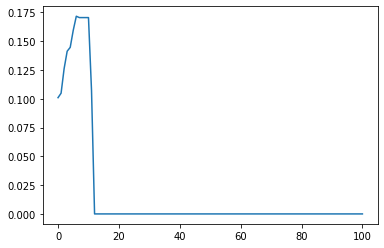

In [47]:
%%time
if description["BERT"]["actif"]:
    bert_model.save("BERT")
    #     pred_bert_proba = bert_model.predict(
    #         np.array(
    #             [create_bert_input_target(x, description["BERT"]) for x in X_test.values]
    #         )
    #     )
    pred_bert_proba = bert_model.predict(
        p5_nlp_utils.Bert.create_bert_inputs(X_test.values, description["BERT"])
    )
    print(pred_bert_proba)
    best, f1_score_avg = p5_nlp_utils.Commun.find_best_limit(
        pred_bert_proba, y_test, target_names
    )
    pred_bert = p5_nlp_utils.Commun.convert_pred_to_bool(pred_bert_proba, limit=best)
    #     print(pred_bert.value_counts())
    scores_bert = p5_nlp_utils.Commun.save_score(
        y_test,
        pred_bert,
        target_names,
        "BERT",
    )
    print(scores_bert.sort_values(by="f1-score", ascending=False))

In [48]:
# # detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# # instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
# with tpu_strategy.scope():
# ...

In [49]:
# %%time
# model = BertTransformer(list(X_train[0:5]), params=description["BERT"])
# model

In [50]:
# %%time
# model = BertTransformer(list(X_train[0:50_000]), params=description["BERT"])
# # model = BertTransformer(list(X_train), params=description["BERT"])
# model
# # model.mean(axis=1)

# USE

In [51]:
%%time
if description["USE"]["actif"]:
    import tensorflow_hub as hub

    embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
    X_train_use = embed(X_train.values)
    print(X_train_use.numpy().shape)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.78 µs


In [52]:
%%time
if description["USE"]["actif"]:
    USEkerasPipeline = tf.keras.models.Sequential(
        [
            tf.keras.Input(shape=(512,)),  # tensor=X_train_use),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(21, activation="sigmoid"),
        ]
    )
    USEkerasPipeline.compile(
        optimizer="adam",
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"],
    )
    USEkerasPipeline.fit(
        X_train_use.numpy(),
        y_train,
        epochs=description["USE"]["epochs"],
        verbose=2,
    )

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.4 µs


In [53]:
%%time
if description["USE"]["actif"]:
    X_pred_test_use = USEkerasPipeline.predict(embed(X_test.values))
    #     print(X_pred_test_use)
    best, f1_score_avg = p5_nlp_utils.Commun.find_best_limit(
        X_pred_test_use, y_test, target_names, limits=np.linspace(0, 1, 101)
    )
    pred_use_bool = p5_nlp_utils.Commun.convert_pred_to_bool(
        X_pred_test_use, limit=best
    )
    use_pred_test_score = p5_nlp_utils.Commun.save_score(
        y_true=y_test,
        y_pred=pred_use_bool,
        target_names=target_names,
        name="kerasUSE",
    )
    print("Sur le jeu test:")
    print(use_pred_test_score.sort_values(by="f1-score", ascending=False))
    USEkerasPipeline.save("kerasUSE")

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.3 µs


In [54]:
if description["USE"]["actif"] and description["USE"]["tsne_visu"]:
    use_pred_train = USEkerasPipeline.predict(X_train_use)
    use_pred_train_bool = convert_pred_to_bool(use_pred_train)
    use_pred_train_score = p5_nlp_utils.Commun.save_score(
        y_true=y_train, y_pred=use_pred_train_bool, target_names=target_names, name=None
    )
    print("Sur le jeu d'entrainement:")
    print(use_pred_train_score.sort_values(by="f1-score", ascending=False))

In [55]:
%%time
if description["USE"]["actif"] and description["USE"]["tsne_visu"]:
    X_train_use_tsne = p5_nlp_utils.Commun.calcul_tsne(X_train_use)
    print("Tag Réél:")
    p5_nlp_utils.Commun.visu_tsne(
        X_tsne=X_train_use_tsne,
        y_train_monodim=y_train_monodim,
        y_train=y_train,
        target_names=target_names,
        tag_list=[
            "java",
            "c#",
            "python",
            "android",
            "php",
            ".net",
            "mysql",
            "sql",
            "javascript",
            "jquery",
            "html",
            "node.js",
            "css",
            "c",
            "mysql",
            "linux",
            "git",
        ],
    )
    print("Tag prédit:")
    p5_nlp_utils.Commun.visu_tsne(
        X_tsne=X_train_use_tsne,
        y_train_monodim=y_train_monodim,
        y_train=use_pred_train_bool,
        target_names=target_names,
        tag_list=[
            "python",
            "java",
            "git",
            "android",
        ],
        maxcols=2,
    )

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10 µs


# LDA 

In [56]:
# import importlib

# importlib.reload(p5_nlp_utils)

In [57]:
import warnings

In [58]:
%%time
lda_models = {}
if description["LDA"]["actif"]:
    print(description["LDA"])
    X_train_tokens = X_train.str.split()
    nb_num_topics = len(description["LDA"]["num_topics"])
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    for indice, num_topics in enumerate(description["LDA"]["num_topics"]):
        print(f"Début {num_topics} {indice+1}/{nb_num_topics}")
        lda_model = p5_nlp_utils.LDA(tokens=X_train_tokens, num_topics=num_topics)
        lda_model.word_cloud_by_topics()
        lda_models[indice] = lda_model.prepare_display()

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 10.5 µs


### Affichage des topics avec pyLDAvis:

In [59]:
pyLDAvis.display(lda_models[0].display_data) if lda_models and lda_models.get(
    0, False
) else None

In [60]:
pyLDAvis.display(lda_models[1].display_data) if lda_models and lda_models.get(
    1, False
) else None

In [61]:
pyLDAvis.display(lda_models[2].display_data) if lda_models and lda_models.get(
    2, False
) else None

In [62]:
# pyLDAvis.prepared_data_to_html(lda_models[0].display_data)